In [7]:
import json
import glob

import numpy as np
import seaborn as sns

from tqdm import tqdm

from utils.utils import(
    read_jsonl,
    get_majority_answer,
    extract_rawdata_answer,
    extract_completion_answer,
    few_shot_prompt, INVALID_ANS,
)

In [2]:
files = glob.glob("./result/model_outputs_*.json")
files = sorted(files, key=lambda x: int(x.split("_")[-1][:-5]), reverse=False)
gsm_8k_test = read_jsonl("./data/test.jsonl")
gt_ans_list = [float(extract_rawdata_answer(gsm_8k_item['answer'])) for gsm_8k_item in gsm_8k_test]

In [4]:
# q_idx = 0
check_samples = 2 ** np.arange(9)
extract_results = {i : [] for i in check_samples}
for filename in tqdm(files):
    with open(filename, "r+") as f:
        read_results = json.load(f)
    for questions in read_results:
        ans = [extract_completion_answer(i) for i in questions ]
        for i in extract_results:
            extract_results[i] += [get_majority_answer(ans[:i])]

100%|██████████| 14/14 [00:06<00:00,  2.30it/s]


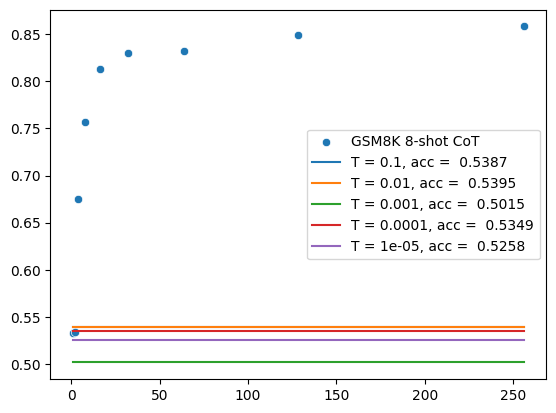

In [31]:
def check_ans(pre_ans_list, gt_ans_list):
    correct_count, all_testcase_count = 0, 0
    for pre_ans, gt_ans in zip(pre_ans_list, gt_ans_list):
        if (pre_ans is not None)  and (abs(pre_ans - gt_ans) < 1e-3):
            correct_count += 1
        all_testcase_count += 1
    return correct_count, all_testcase_count
acc_all = []
for i in extract_results:
    correct_count, all_testcase_count = check_ans(extract_results[i], gt_ans_list)
    acc_all += [correct_count / all_testcase_count]
    
sns.scatterplot(x = check_samples, y = acc_all, label = "GSM8K 8-shot CoT")

greedy_ans = []
for T in [0.1,0.01,0.001,0.0001,1e-5]:
    greedy_ans = []
    with open(f"./result/low_T_model_outputs_T={T}.json", "r+") as f:
        read_results = json.load(f)
    for questions in read_results:
        ans = extract_completion_answer(questions[0])
        
        greedy_ans += [float(ans if ans != '[invalid]' else -9999)]
    correct_count, all_testcase_count = check_ans(greedy_ans, gt_ans_list)
    sns.lineplot(x = check_samples, y = [correct_count / all_testcase_count] * check_samples.shape[0], label = f"T = {T}, acc = {correct_count / all_testcase_count : .4f}")


In [29]:
acc_all[0]

0.5329795299469295